In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
csv_file_path = "reward_log/npc_vehicle_reward.csv"
df = pd.read_csv(csv_file_path)

In [3]:
# General description of the data
df.describe()

,waypoint_reward,max_speed_reward,ego_collision_reward,npc_collision_reward,episode_id
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.830280,-0.561035,0.592309,-0.172500,178.597850
std,2.958954,0.432163,4.193555,3.015908,101.247262
min,0.000000,-3.207841,0.000000,-100.000000,1.000000
25%,0.000000,-0.860436,0.000000,0.000000,90.000000
50%,1.152465,-0.472471,0.000000,0.000000,180.000000
75%,2.356534,-0.217908,0.000000,0.000000,269.000000
max,71.571695,0.000000,67.735304,0.000000,348.000000


### Episode-wise analysis


In [4]:
def separate_reward_dataframes(
    df: pd.DataFrame, reward_suffix: str = "_reward"
) -> "dict[str, pd.DataFrame]":
    """
    Separates the dataframe into multiple dataframes, each containing data for a specific reward type.

    Args:
        df (pd.DataFrame): The original dataframe.
        reward_suffix (str): The suffix used to identify reward columns.

    Returns:
        dict: A dictionary where keys are reward column names and values are corresponding dataframes.
    """
    reward_dfs = {}
    for column in df.columns:
        if column.endswith(reward_suffix):
            # Creating a new dataframe for each reward type
            reward_df = df[["episode_id", column]]
            # Aggregating data by 'episode_id'
            aggregated_reward_df = reward_df.groupby("episode_id").agg(
                ["sum", "mean", "std", "min", "max", "count"]
            )
            # Renaming columns for clarity
            aggregated_reward_df.columns = [
                "{}_{}".format(column, stat)
                for stat in ["sum", "mean", "std", "min", "max", "count"]
            ]
            reward_dfs[column] = aggregated_reward_df

    return reward_dfs

In [5]:
grouped_df = separate_reward_dataframes(df)

In [6]:
print(grouped_df.keys())

dict_keys(['waypoint_reward', 'max_speed_reward', 'ego_collision_reward', 'npc_collision_reward'])


In [7]:
grouped_df["waypoint_reward"].head()

,waypoint_reward_sum,waypoint_reward_mean,waypoint_reward_std,waypoint_reward_min,waypoint_reward_max,waypoint_reward_count
episode_id,,,,,,
1,16.831582,0.801504,1.420567,0.0,4.590411,21
2,73.322328,3.055097,3.672560,0.0,17.213350,24
3,134.413244,2.317470,2.774423,0.0,20.161071,58
4,98.291956,1.156376,1.639954,0.0,13.703241,85
5,48.422508,0.849518,1.101781,0.0,7.050783,57


### Plot


In [8]:
def calculate_grid_dimensions(n_plots: int, rows: int = None, cols: int = None):
    """
    Calculate the number of rows and columns for the grid layout based on the number of plots.

    Args:
        n_plots (int): The number of plots to display.
        rows (int): The number of rows desired (optional).
        cols (int): The number of columns desired (optional).

    Returns:
        tuple: A tuple containing the number of rows and columns for the grid layout.
    """
    if rows and not cols:
        cols = math.ceil(n_plots / rows)
    elif cols and not rows:
        rows = math.ceil(n_plots / cols)
    else:
        # If neither rows nor cols are specified, calculate a square (or nearly square) layout
        rows = cols = math.ceil(math.sqrt(n_plots))

    return rows, cols


def plot_time_series(
    reward_dfs: "dict[str, pd.DataFrame]",
    indicator: str = "sum",
    rows: int = None,
    cols: int = None,
):
    """
    Plots time series for each reward type in a grid layout.

    Args:
        reward_dfs (dict): A dictionary of dataframes, each containing data for a specific reward type.
        indicator (str): The indicator to plot. Must be one of 'sum', 'mean', 'std', 'min', 'max', or 'count'.
        rows (int): Number of rows in the grid (optional).
        cols (int): Number of columns in the grid (optional).
    """
    assert indicator in [
        "sum",
        "mean",
        "std",
        "min",
        "max",
        "count",
    ], "Indicator must be one of 'sum', 'mean', 'std', 'min', 'max', or 'count'."

    sns.set(style="whitegrid")
    n_plots = len(reward_dfs)
    rows, cols = calculate_grid_dimensions(n_plots, rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for ax, (reward_type, df) in zip(axes, reward_dfs.items()):
        ax.plot(
            df.index,
            df[f"{reward_type}_{indicator}"],
            marker="o",
            label=f"{indicator.capitalize()} of {reward_type}",
        )
        ax.set_title(f"Time Series of {reward_type} Over Episodes")
        ax.set_xlabel("Episode ID")
        ax.set_ylabel(f"{indicator.capitalize()} of {reward_type}")
        ax.legend()

    # Hide any unused subplots
    for ax in axes[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()


def plot_box_plots(
    reward_dfs: "dict[str, pd.DataFrame]",
    original_df: pd.DataFrame,
    rows: int = None,
    cols: int = None,
):
    """
    Creates box plots for each reward type in a grid layout.

    Args:
        reward_dfs (dict): A dictionary of dataframes, each containing data for a specific reward type.
        original_df (pd.DataFrame): The original dataframe.
        rows (int): Number of rows in the grid (optional).
        cols (int): Number of columns in the grid (optional).
    """
    sns.set(style="whitegrid")
    n_plots = len(reward_dfs)
    rows, cols = calculate_grid_dimensions(n_plots, rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for ax, reward_type in zip(axes, reward_dfs.keys()):
        sns.boxplot(x="episode_id", y=reward_type, data=original_df, ax=ax)
        ax.set_title(f"Distribution of {reward_type} per Episode")
        ax.set_xlabel("Episode ID")
        ax.set_ylabel(reward_type)

    # Hide any unused subplots
    for ax in axes[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()

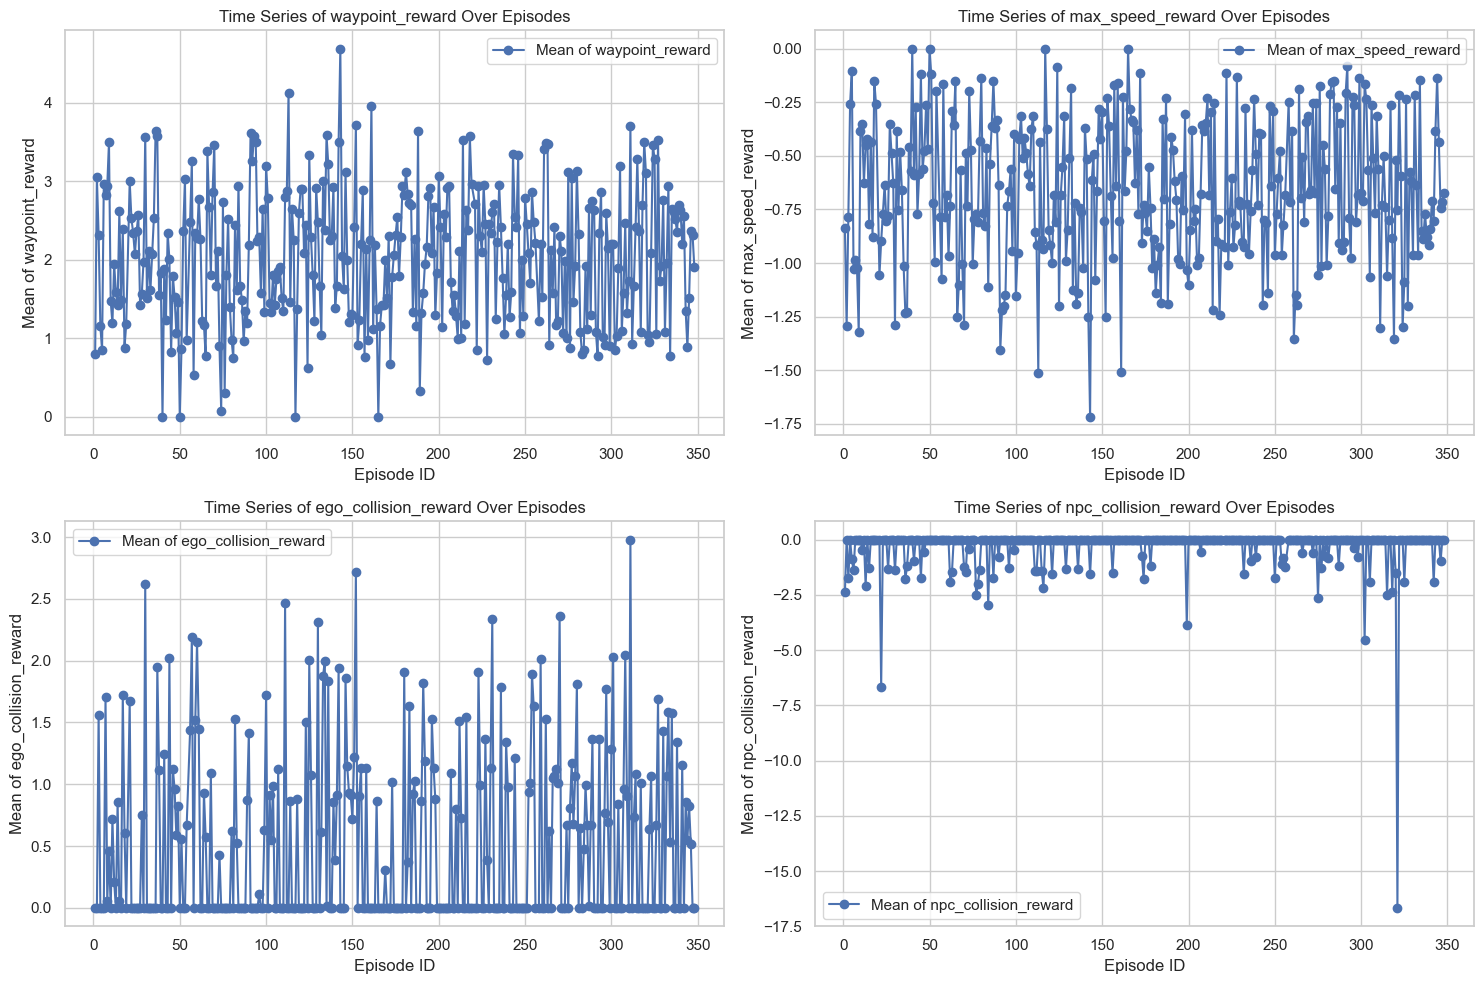

In [9]:
plot_time_series(grouped_df, indicator="mean")

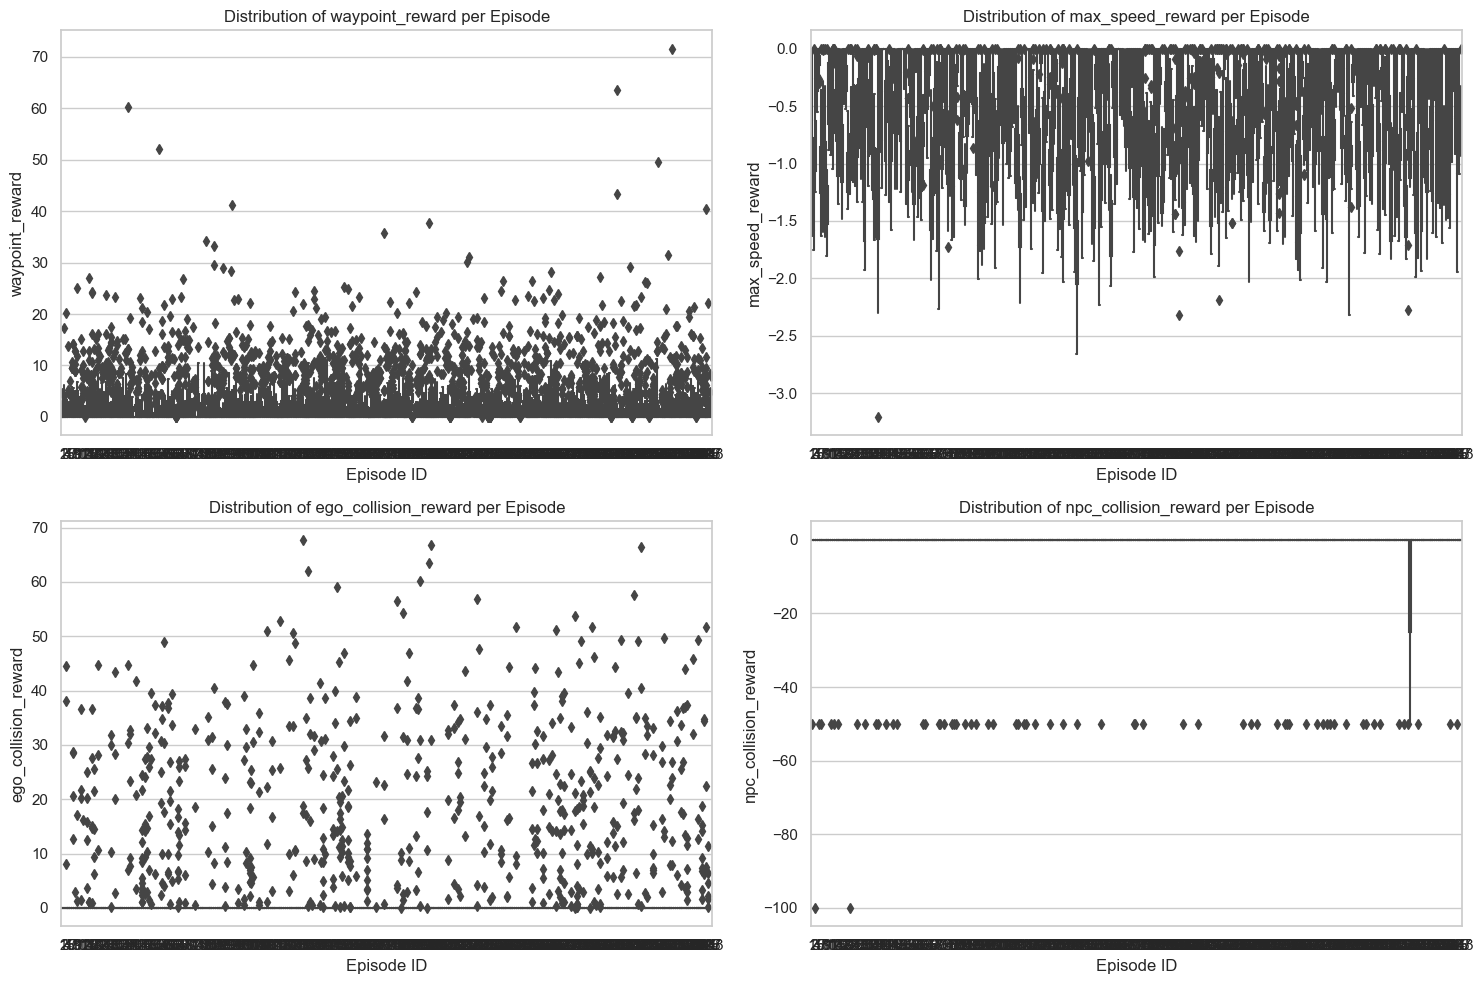

In [10]:
plot_box_plots(grouped_df, df)